## HyperTuneCIFAR: Hyperparameter Tuning on AlexNet for CIFAR-10 Image Classification

**Goal**: Perform grid search for hyperparameter tuning on the AlexNet neural network to achieve higher accuracy in image classification with the CIFAR-10 dataset.

### Load libraries

In [1]:
import torch

# Prepare data
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

# Build AlexNet neural network
from torch import nn

# Grid search
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

### See CIFAR10 dataset

In [2]:
root = '' # Root folder location for CIFAR-10 dataset

In [3]:
cifar10 = CIFAR10(root=root, download=True)
cifar10

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../data
    Split: Train

In [6]:
cifar10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
import matplotlib.pyplot as plt

Label: truck
<PIL.Image.Image image mode=RGB size=32x32 at 0x157302E9AC0>


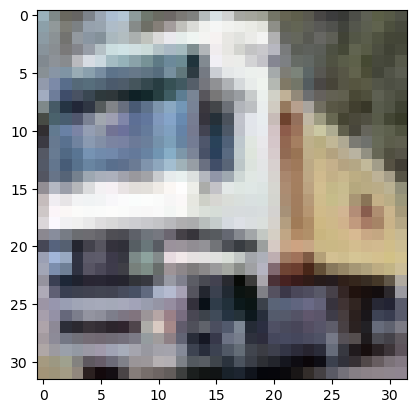

: 

In [7]:
image, label = cifar10[1]
print("Label:", cifar10.classes[label])
print(image)
plt.imshow(image)
plt.show()

### AlexNet implementation

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        '''Forward propagation'''
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### Prepare CIFAR-10 data

In [ ]:
device = 'cuda'

In [414]:
train_normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)
test_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomCrop(120, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    train_normalize,
])
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    test_normalize
])

train_data = CIFAR10(root=root, train=True, transform=train_transform)
test_data = CIFAR10(root=root, train=False, transform=test_transform)

train = DataLoader(train_data, batch_size=300)

### Perform grid search

In [ ]:
from torch import optim

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

In [ ]:
num_classes = 10 # len(train.dataset.classes)
num_epochs = 5

model = NeuralNetClassifier(
    AlexNet,
    criterion = nn.CrossEntropyLoss,
    max_epochs = num_epochs,
    device = device
)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 20, 50, 80, 110],
    'optimizer__lr': [0.001, 0.01, 0.1, 0.2, 0.3],
    'optimizer': [optim.SGD, optim.Adagrad, optim.Adam, optim.RMSprop],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    refit=False, scoring='accuracy', verbose=1, cv=2)

In [415]:
# Perform grid search one batch at a time
max_search = 10 # Number of times to run fit for grid search
num_search = 0 # Counter
for i, (images, labels) in enumerate(train):
    grid_result = grid.fit(images, labels) # Grid search
    num_search += 1
    if num_search >= max_search:
        break

Fitting 2 folds for each of 100 candidates, totalling 200 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3774       0.1000        2.3023  0.4846
      2        2.2839       0.1333        2.2930  0.2357
      3        2.3152       0.1333        2.2651  0.2327
      4        2.2440       0.1333        2.2470  0.2406
      5        2.2425       0.1667        2.2312  0.2455
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3636       0.1333        2.3009  0.2326
      2        2.3114       0.1333        2.2940  0.2320
      3        2.2764       0.1000        2.2809  0.2409
      4        2.2508       0.1000        2.2749  0.2361
      5        2.2368       0.1333        2.2710  0.2351
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.5083    

In [416]:
# Summarize results
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean %f, stdev %f using %r" % (mean, stdev, param))

Best: 0.210000 using {'batch_size': 10, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'optimizer__lr': 0.001}

Mean 0.143333, stdev 0.003333 using {'batch_size': 10, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
Mean 0.186667, stdev 0.013333 using {'batch_size': 10, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.01}
Mean 0.150000, stdev 0.016667 using {'batch_size': 10, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.1}
Mean 0.113333, stdev 0.000000 using {'batch_size': 10, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.2}
Mean 0.116667, stdev 0.010000 using {'batch_size': 10, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.3}
Mean 0.210000, stdev 0.016667 using {'batch_size': 10, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'optimizer__lr': 0.001}
Mean 0.100000, stdev 0.000000 using {'batch_size': 10, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'optimizer__lr': 0.01}
Mean 0.100000,

Optimal parameters:
- Batch size - 10
- Optimizer - Adagrad
- Optimizer learning rate - 0.001

In [ ]:
# Setup data and parameters for model based on grid search results
batch_size = 10
learning_rate = 0.001

train = DataLoader(train_data, batch_size=batch_size)
test = DataLoader(test_data, batch_size=batch_size)

model = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))


Epoch [1/20], Loss: 1.3620
Accuracy of the network on the 5000 validation images: 75.42 %
Epoch [2/20], Loss: 1.0313
Accuracy of the network on the 5000 validation images: 74.82 %
Epoch [3/20], Loss: 0.9298
Accuracy of the network on the 5000 validation images: 76.49 %
Epoch [4/20], Loss: 0.6103
Accuracy of the network on the 5000 validation images: 76.68 %
Epoch [5/20], Loss: 1.0448
Accuracy of the network on the 5000 validation images: 77.53 %
Epoch [6/20], Loss: 0.9988
Accuracy of the network on the 5000 validation images: 77.0 %
Epoch [7/20], Loss: 0.5881
Accuracy of the network on the 5000 validation images: 77.26 %
Epoch [8/20], Loss: 0.5998
Accuracy of the network on the 5000 validation images: 77.37 %
Epoch [9/20], Loss: 0.8394
Accuracy of the network on the 5000 validation images: 77.55 %
Epoch [10/20], Loss: 1.1716
Accuracy of the network on the 5000 validation images: 77.87 %
Epoch [11/20], Loss: 0.7032
Accuracy of the network on the 5000 validation images: 77.79 %
Epoch [12